##Sentiment Analysis
* Classification of people's opinion or expressions into different sentiments such as Positive,Neutral and Negative.

Importing Necessary Libraries

In [1]:
!pip install pyspellchecker

     |████████████████████████████████| 1.9MB 2.8MB/s 


In [78]:
%matplotlib inline

In [2]:
# to hide warnings
import warnings
warnings.filterwarnings('ignore')

# basic data processing
import os
import datetime
import pandas as pd
import numpy as np

# for EDA
from pandas_profiling import ProfileReport

# for text preprocessing
import re
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from spellchecker import SpellChecker

# progress bar
from tqdm.auto import tqdm
from tqdm import tqdm_notebook

# instantiate
tqdm.pandas(tqdm_notebook)

# for wordcloud
from PIL import Image
from wordcloud import WordCloud

# for aesthetics and plots
from IPython.display import display, Markdown, clear_output
from termcolor import colored

import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.offline import plot, iplot
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "notebook"

# for model
import tensorflow as tf
import tensorflow_hub as hub
import keras.layers as layers
from keras.models import Model
from keras import backend as K
import keras
from keras.models import load_model

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
data=pd.read_csv('BeforeLD.csv')

In [4]:
data.head(5)

,id,created_at,original_text,clean_text,polarity,subjectivity,favorite_count,retweet_count,possibly_sensitive,hashtags,user_mentions,place
0,1200462491156963328,Fri Nov 29 17:12:16 +0000 2019,It's another SustyFriday. Today we wade into ...,It 's another SustyFriday Today wade Air Pollu...,0.000000,0.000000,13,8,False,"Sustyfacts, Sustyfriday",SustyVibes,NaN
1,1200469208917823488,Fri Nov 29 17:38:57 +0000 2019,Get the required information and knowledge abo...,Get required information knowledge Thank thread,0.000000,0.000000,0,1,False,"AirPollution, Nigeria, StareDownOnPollution, B...",cylexi,"Lagos, Nigeria"
2,1191998173176356864,Wed Nov 06 08:38:05 +0000 2019,#AirPollution kills 7 million people every yea...,kills million people every year main driver Ch...,0.275556,0.457778,0,0,False,"AirPollution, ClimateChange",NaN,"Lagos, Nigeria"
3,1211632839185313798,Mon Dec 30 12:59:14 +0000 2019,Climate Change can Bastardize the ecological f...,Climate Change Bastardize ecological footprint...,-0.115909,0.530303,0,1,False,NaN,NaN,"Ikeja, Nigeria"
4,1191944548412469248,Wed Nov 06 05:05:00 +0000 2019,Pollution in Delhi has hit dangerous levels - ...,Pollution Delhi hit dangerous levels entering ...,-0.600000,0.900000,250,169,False,NaN,NaN,NaN


In [8]:
data.isnull().sum()

id                     0
created_at             0
original_text          0
clean_text             2
polarity               0
subjectivity           0
favorite_count         0
retweet_count          0
possibly_sensitive    16
hashtags              25
user_mentions         48
place                 13
dtype: int64

In [10]:
data.polarity.unique()

array([ 0.        ,  0.27555556, -0.11590909, -0.6       , -0.01515152,
       -0.625     ,  0.65      ,  0.44166667, -0.1       ,  0.2       ,
        0.6       ,  0.3       ,  0.5       , -0.4       ,  0.7       ,
        0.4       ,  0.25625   ,  0.18333333,  1.        ,  0.05      ,
        0.1       , -0.02916667,  0.3125    ,  0.32083333,  0.21666667,
        0.06393939, -0.2       , -0.1       ,  0.13636364,  0.39166667,
        0.04      ,  0.375     ,  0.3875    ,  0.25      ,  0.8       ,
        0.11666667, -0.1375    ,  0.47      ])

In [11]:
def get_sentiment(value):
  if value > 0:
        return 'positive'
  elif value == 0:
        return 'neutral'
  else:
        return 'negative'

In [12]:
data['sentiment']=data['polarity'].apply(get_sentiment)
data

,id,created_at,original_text,clean_text,polarity,subjectivity,favorite_count,retweet_count,possibly_sensitive,hashtags,user_mentions,place,sentiment
0,1200462491156963328,Fri Nov 29 17:12:16 +0000 2019,It's another SustyFriday. Today we wade into ...,It 's another SustyFriday Today wade Air Pollu...,0.000000,0.000000,13,8,False,"Sustyfacts, Sustyfriday",SustyVibes,NaN,neutral
1,1200469208917823488,Fri Nov 29 17:38:57 +0000 2019,Get the required information and knowledge abo...,Get required information knowledge Thank thread,0.000000,0.000000,0,1,False,"AirPollution, Nigeria, StareDownOnPollution, B...",cylexi,"Lagos, Nigeria",neutral
2,1191998173176356864,Wed Nov 06 08:38:05 +0000 2019,#AirPollution kills 7 million people every yea...,kills million people every year main driver Ch...,0.275556,0.457778,0,0,False,"AirPollution, ClimateChange",NaN,"Lagos, Nigeria",positive
3,1211632839185313798,Mon Dec 30 12:59:14 +0000 2019,Climate Change can Bastardize the ecological f...,Climate Change Bastardize ecological footprint...,-0.115909,0.530303,0,1,False,NaN,NaN,"Ikeja, Nigeria",negative
4,1191944548412469248,Wed Nov 06 05:05:00 +0000 2019,Pollution in Delhi has hit dangerous levels - ...,Pollution Delhi hit dangerous levels entering ...,-0.600000,0.900000,250,169,False,NaN,NaN,NaN,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,1219283399262851074,Mon Jan 20 15:39:50 +0000 2020,What should be the #1 priority for the @IMOHQ ...,What priority Secretary General starts second ...,-0.137500,0.475000,0,0,False,"emissions, ClimateCrisis",IMOHQ,"Nairobi, Kenya",negative
72,1217660584000479232,Thu Jan 16 04:11:20 +0000 2020,Capitol of Ethiopia and African Union bathing ...,Capitol Ethiopia African Union bathing morning...,0.000000,0.000000,4,0,False,"smog, airquality, urbanization, megatrends","mega_sense, INAR_fin","Nairobi, Kenya",neutral
73,1212994404111265792,Fri Jan 03 07:09:36 +0000 2020,First run 🏃 in Jan 2020. Few days ago I was at...,First run Jan Few days ago I home air pollutio...,0.470000,0.586667,60,27,False,AirPollution,governorkingi,"Kilifi, Kenya",positive
74,1233718989521637376,Sat Feb 29 11:41:43 +0000 2020,#AirPollution is an existential urban developm...,existential urban development threat This comi...,0.000000,0.000000,9,7,False,"AirPollution, KlaCleanAir, UgandaGreenGrowth",KCCAUG,Golden Tulip Hotel,neutral


**EDA**

In [15]:
data.describe()

,id,polarity,subjectivity,favorite_count,retweet_count
count,7.600000e+01,76.000000,76.000000,76.000000,76.000000
mean,1.213157e+18,0.154148,0.372954,113.723684,38.105263
std,1.663842e+16,0.307603,0.321293,603.490571,201.369086
min,1.190203e+18,-0.625000,0.000000,0.000000,0.000000
25%,1.200417e+18,0.000000,0.000000,0.000000,0.000000
50%,1.211759e+18,0.045000,0.400000,2.000000,0.000000
75%,1.228017e+18,0.388542,0.540625,11.500000,4.000000
max,1.244402e+18,1.000000,1.000000,4180.000000,1492.000000


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  76 non-null     int64  
 1   created_at          76 non-null     object 
 2   original_text       76 non-null     object 
 3   clean_text          74 non-null     object 
 4   polarity            76 non-null     float64
 5   subjectivity        76 non-null     float64
 6   favorite_count      76 non-null     int64  
 7   retweet_count       76 non-null     int64  
 8   possibly_sensitive  60 non-null     object 
 9   hashtags            51 non-null     object 
 10  user_mentions       28 non-null     object 
 11  place               63 non-null     object 
 12  sentiment           76 non-null     object 
dtypes: float64(2), int64(3), object(8)
memory usage: 7.8+ KB


Dropping irrelevant columns

In [22]:
data.clean_text.dropna()

0     It 's another SustyFriday Today wade Air Pollu...
1       Get required information knowledge Thank thread
2     kills million people every year main driver Ch...
3     Climate Change Bastardize ecological footprint...
4     Pollution Delhi hit dangerous levels entering ...
                            ...                        
71    What priority Secretary General starts second ...
72    Capitol Ethiopia African Union bathing morning...
73    First run Jan Few days ago I home air pollutio...
74    existential urban development threat This comi...
75    Jane Rendell makes facilitation breakout sessi...
Name: clean_text, Length: 74, dtype: object

In [24]:
data.columns

Index(['id', 'created_at', 'original_text', 'clean_text', 'polarity',
       'subjectivity', 'favorite_count', 'retweet_count', 'possibly_sensitive',
       'hashtags', 'user_mentions', 'place', 'sentiment'],
      dtype='object')

In [26]:
df=data.copy()
df.drop(['id', 'created_at', 'original_text', 'polarity',
       'subjectivity', 'favorite_count', 'retweet_count', 'possibly_sensitive',
       'hashtags', 'user_mentions', 'place'],axis=1,inplace=True)
df

,clean_text,sentiment
0,It 's another SustyFriday Today wade Air Pollu...,neutral
1,Get required information knowledge Thank thread,neutral
2,kills million people every year main driver Ch...,positive
3,Climate Change Bastardize ecological footprint...,negative
4,Pollution Delhi hit dangerous levels entering ...,negative
...,...,...
71,What priority Secretary General starts second ...,negative
72,Capitol Ethiopia African Union bathing morning...,neutral
73,First run Jan Few days ago I home air pollutio...,positive
74,existential urban development threat This comi...,neutral


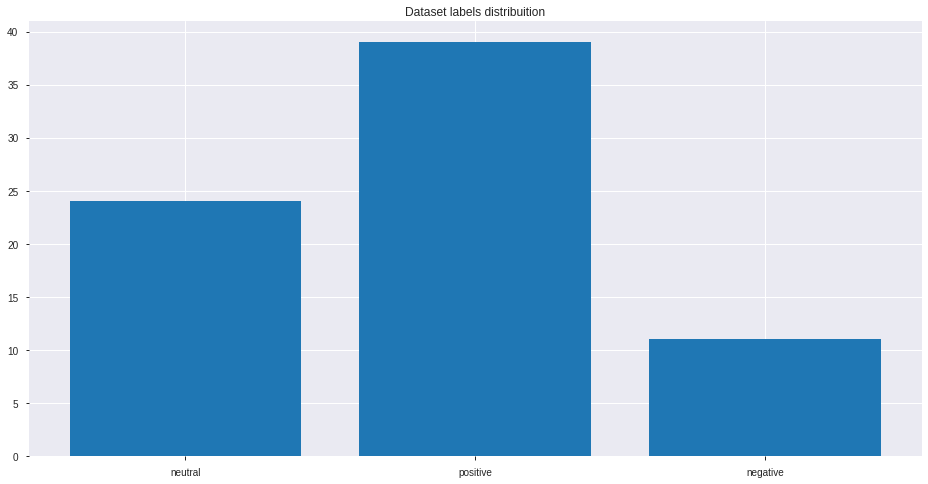

In [79]:
from collections import Counter
target_cnt = Counter(df.sentiment)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")
plt.show()

>>>More positive text,then,neutral then negative.


In [28]:
# set of stop words declared
stop_words = stopwords.words('english')

updated_stop_words = stop_words.copy()
for word in stop_words:
    if "n't" in word or "no" in word or word.endswith('dn') or word.endswith('sn') or word.endswith('tn'):
        updated_stop_words.remove(word)

# custom select words you don't want to eliminate
words_to_remove = ['for','by','with','against','shan','don','aren','haven','weren','until','ain','but','off','out']
for word in words_to_remove:
    updated_stop_words.remove(word)

In [54]:
df.dropna(inplace=True)
df.isnull().sum()

clean_text    0
sentiment     0
dtype: int64

In [57]:
import nltk
nltk.download('wordnet')

# creating instance of lemmatizer
lemm = WordNetLemmatizer()
def preprocess(tweet):
  #lowercase the tweets
  #try:
  tweet =tweet.lower().strip()
  #except AttributeError as e:
  #  tweet =tweet.astype(str).lower().strip()
  #  continue 

  splitted_tweet=tweet.split()

  tweetwords=''

  for word in splitted_tweet:
    #checking if the word is a stopword
    if word not in updated_stop_words:
      if len(word)>1:
        #lemmatize the word
        lem_word=lemm.lemmatize(word)
        tweetwords+=(lem_word +' ')
  return tweetwords

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [58]:
df['text']=df['clean_text'].apply(preprocess)
df.head(5)

,clean_text,sentiment,text
0,It 's another SustyFriday Today wade Air Pollu...,neutral,'s another sustyfriday today wade air pollutio...
1,Get required information knowledge Thank thread,neutral,get required information knowledge thank thread
2,kills million people every year main driver Ch...,positive,kill million people every year main driver chi...
3,Climate Change Bastardize ecological footprint...,negative,climate change bastardize ecological footprint...
4,Pollution Delhi hit dangerous levels entering ...,negative,pollution delhi hit dangerous level entering `...


In [85]:
def plot_wordcloud(text, title = None):
    wordcloud = WordCloud(background_color='black', max_words = 200,
                          max_font_size = 20, random_state = 42)
    wordcloud.generate(text)
    
    plt.figure(figsize=(18,17))
    
    plt.imshow(wordcloud)
    plt.title(title, fontdict={'size': 40, 'verticalalignment': 'bottom'})
    plt.axis('off')
    #plt.tight_layout()
    plt.show()

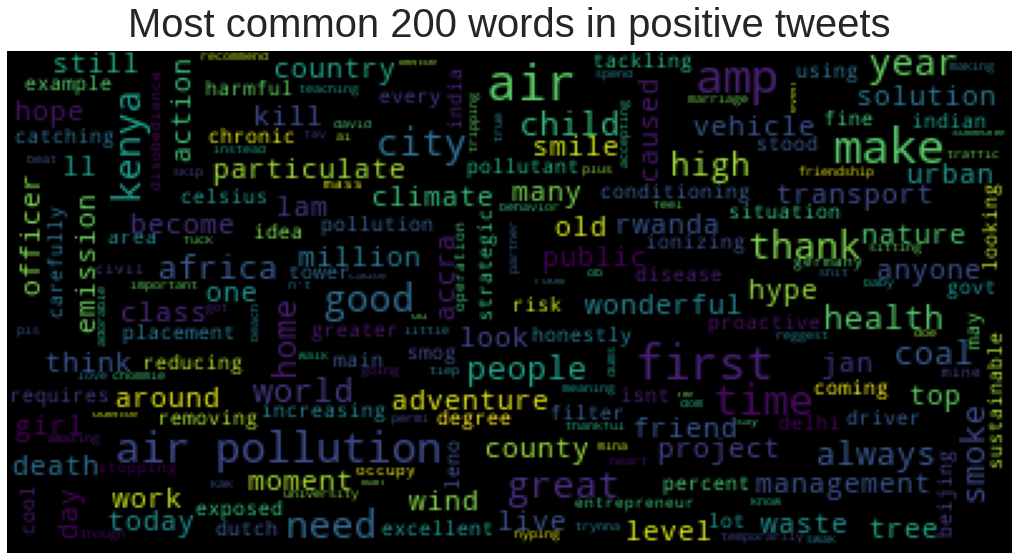

In [86]:
pos_text = " ".join(df[df['sentiment'] == 'positive']['text'])


plot_wordcloud(pos_text,  title = 'Most common 200 words in positive tweets')


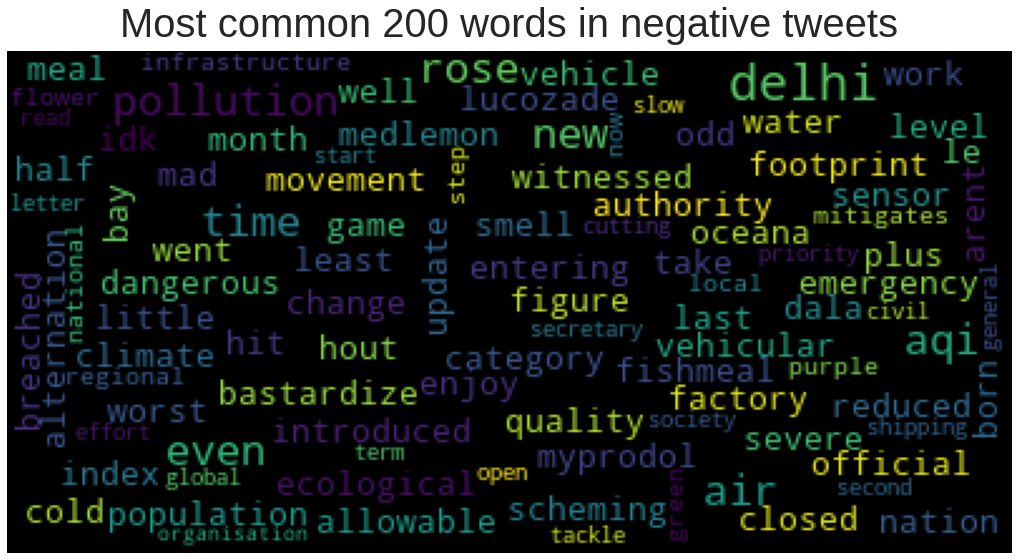

In [87]:
neg_text = " ".join(df[df['sentiment'] == 'negative'].text)


plot_wordcloud(neg_text, title = 'Most common 200 words in negative tweets')

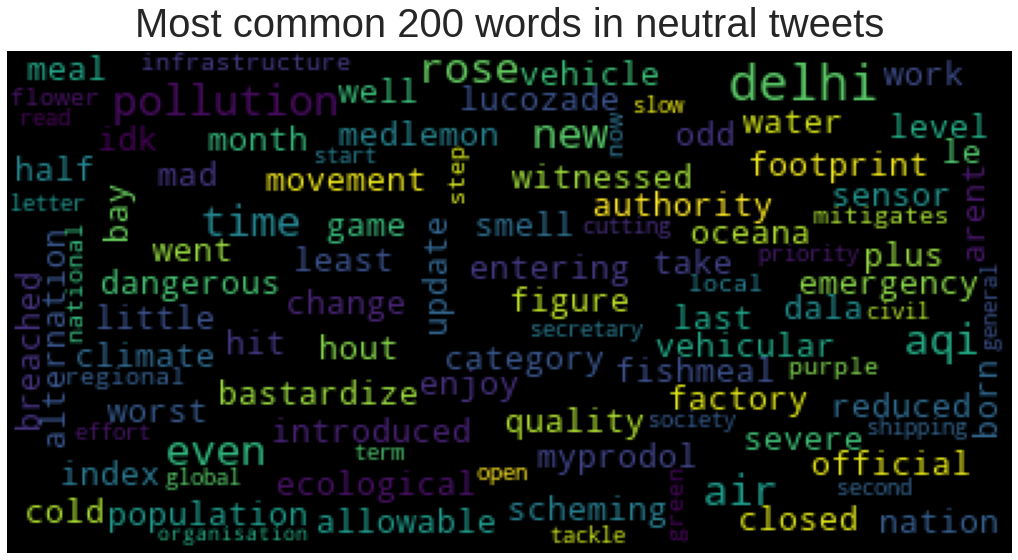

In [88]:
neutral_text = " ".join(df[df['sentiment'] == 'neutral'].text)


plot_wordcloud(neg_text, title = 'Most common 200 words in neutral tweets')

**DATA SPLIT**

In [91]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=369):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.loc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.loc[perm[validate_end:]]
    return train, validate, test

train_df, val_df, test_df = train_validate_test_split(df)

print('Train: {}, Validation: {}, Test: {}'.format(train_df.shape, val_df.shape, test_df.shape))

print(colored('\nTRAIN DATA','magenta',attrs=['bold']))
display(train_df.head())

train_text = train_df['text'].tolist()
train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_label = np.asarray(pd.get_dummies(train_df['sentiment']), dtype = np.int8)

val_text = val_df['text'].tolist()
val_text = np.array(val_text, dtype=object)[:, np.newaxis]
val_label = np.asarray(pd.get_dummies(val_df['sentiment']), dtype = np.int8)

test_text = test_df['text'].tolist()
test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_label = np.asarray(pd.get_dummies(test_df['sentiment']), dtype = np.int8)

Train: (44, 3), Validation: (14, 3), Test: (16, 3)

TRAIN DATA


,clean_text,sentiment,text
23,I born game Les Dala..,negative,born game le dala..
68,Great hear Netherlands renewed support interes...,positive,great hear netherlands renewed support interes...
31,BBC News Millions masks distributed students '...,neutral,bbc news million mask distributed student 'gas...
29,even though I ai n't shit You still hype fuck ...,positive,even though ai n't shit still hype fuck me.. p...
44,A back I particulates campaign challenge I thi...,positive,back particulate campaign challenge think brin...
